In [1]:
## Standard imports
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import json
import torch
import astroddpm
import tqdm.notebook as tqdm

## Relative imports
from astroddpm.runners import Diffuser, config_from_id, get_samples
from astroddpm.analysis.validationMetrics import powerSpectrum, minkowskiFunctional, basics
from astroddpm.analysis import overfitting_check
from astroddpm.utils.plot import check_nearest_epoch, plot_losses, check_training_samples, plot_comparaison
from astroddpm.diffusion.dm import DiscreteSBM
from astroddpm.diffusion.stochastic.sde import DiscreteVPSDE
from astroddpm.diffusion.models.network import ResUNet
import astroddpm.utils.colormap_custom 

In [2]:
save_fig = True

params = {'text.usetex': True,
         'text.latex.preamble': r'\usepackage{amsmath}',
         "font.family": "serif", "font.serif": ["Computer Modern Roman"],
         'font.size': 12,
         'image.interpolation': 'none'}
plt.rcParams.update(params)

In [3]:
ALL_MODELS = os.path.join(os.path.dirname(astroddpm.__file__), 'config', 'MODELS.json')

with open(ALL_MODELS, 'r') as f:
    ALL_MODELS_DICT = json.load(f)
print(ALL_MODELS_DICT.keys())

dict_keys(['DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_4000_bottleneck_32', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_1000_bottleneck_16', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_4000_bottleneck_16', 'DiscreteSBM_ND_VPSDE_MHD_BPROJ_N_1000_bottleneck_32', 'DiscreteSBM_ND_VPSDE_MHD_BPROJ_N_1000_bottleneck_16', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_8000_bottleneck_16', 'DiscreteSBM_ND_VPSDE_MHD_BPROJ_N_4000_bottleneck_32', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_8000_bottleneck_32', 'DiscreteSBM_ND_VPSDE_MHD_BPROJ_N_4000_bottleneck_16', 'DiscreteSBM_ND_VPSDE_MHD_BPROJ_N_8000_bottleneck_32', 'DiscreteSBM_ND_VPSDE_MHD_BPROJ_N_8000_bottleneck_16', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_1000_bottleneck_32', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_4000_bottleneck_32_betamin_0.01_step', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_4000_bottleneck_32_betamin_0.05_invsqrt', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_1000_bottleneck_16_betamin_0.05_step', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_4000_bottleneck_32_beta

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODEL_ID = 'DiscreteSBM_MultiSigmaVPSDE_I_BPROJ_N_1000_bottleneck_16_firstc_6'

In [5]:
placeholder_dm = DiscreteSBM(DiscreteVPSDE(1000), ResUNet())
diffuser = Diffuser(placeholder_dm)
diffuser.load(config=config_from_id(MODEL_ID), also_ckpt=True, for_training=True)

No model id found
Loading the diffuser from a config dict.
Loading the optimizer and scheduler states from the checkpoint, as well as previous training info. You should change the model id if you want to finetune the model.


## Different images of the problem

In [6]:
batch = next(iter(diffuser.train_dataloader))
batch = batch.to(device).unsqueeze(1)
batch.shape

torch.Size([64, 1, 256, 256])

In [7]:
ps, theta = diffuser.diffmodel.ps.sample_ps(1)
sq_ps = torch.sqrt(ps).to(device)
noisy, mean, noise = diffuser.diffmodel.sde.sampling(batch, 150, sq_ps)

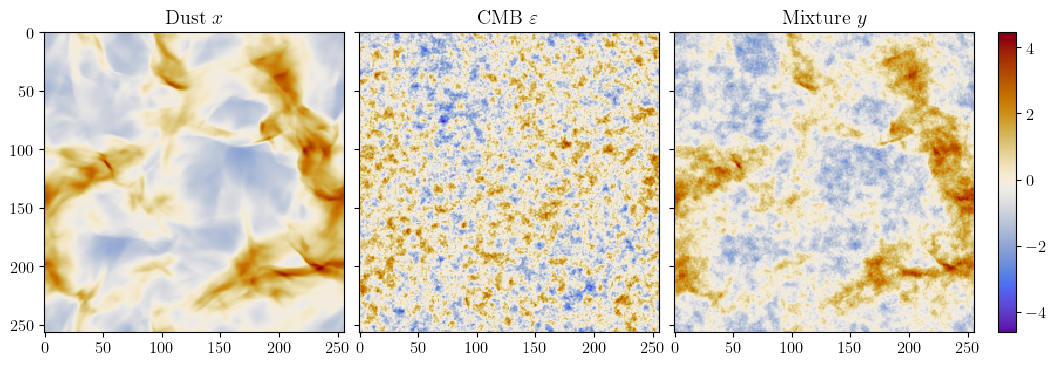

In [8]:
x = batch[0, 0].cpu().numpy()
e = noise[0, 0].cpu().numpy()
y = noisy[0, 0].cpu().numpy()

vmin = np.min([x, e, y])
vmax = np.max([x, e, y])
cmap = 'cmb'

fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
im0 = axs[0].imshow(x, cmap=cmap, vmin=vmin, vmax=vmax)
im1 = axs[1].imshow(e, cmap=cmap, vmin=vmin, vmax=vmax)
im2 = axs[2].imshow(y, cmap=cmap, vmin=vmin, vmax=vmax)
axs[0].set_title('Dust $x$')
axs[1].set_title(r'CMB $\varepsilon$')
axs[2].set_title('Mixture $y$')
fig.colorbar(im0, cax=fig.add_axes([0.92, 0.12, 0.015, 0.75])) # left, bottom, width, height
plt.subplots_adjust(wspace=0.05, hspace=0.05)
if save_fig:
    fig.savefig('figs/data.pdf', bbox_inches='tight')